In [6]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
import os.path
import copy
import cv2 as cv

# if true, reload and process data again, else load the data saved previously in files stored in numpy_arrays
# On a 30 * 30 abdomens + 20 * 30 labelisés au total
RELOAD_DATA = True
nb_dirs_to_load = 1000 # 50 folders total, bigger number means load all
nb_files_to_load_per_dir = 2 # 5 # putting a number bigger than the number of files will just load every file in the folder

# if true, retrain model
DO_WE_LEARN = False
epochs = 20
file_name = "model_simple_3D.hdf5"

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

d:\GitHub\abdomen_segmentation\single_organ_segmentation


In [7]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for j in range(img):
        patient = img[j]
        for i in range(5, 60, 10):
            disp_list.append(patient[i])
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s), -100, 100)

In [8]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    global raw_data
    global labeled_data
    
    raw_patient = []
    labeled_patient = []
    labeled_scan = np.where(labeled_scan == 6, 1, 0).astype('uint8')
    for i in range(scan.shape[2]):
        #if labeled_scan[:, :, i].sum() == 0:
        #    continue
        
        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[5:resized_data.shape[0]-5, 29:resized_data.shape[1]-29]
        resized_data_labeled = resized_data_labeled[5:resized_data_labeled.shape[0]-5, 29:resized_data_labeled.shape[1]-29]

        resized_data = normalize(resized_data, )
        mask_img = np.where(resized_data > -1, 1, 0)
        resized_data_labeled = np.expand_dims(resized_data_labeled, axis=2)
        resized_data = np.expand_dims(resized_data, axis=2)
        mask_img = np.expand_dims(mask_img, axis=2)
        resized_data = np.append(resized_data, mask_img, axis=2)

        raw_patient.append(resized_data)
        labeled_patient.append(resized_data_labeled)

    raw_data.append(np.array(raw_patient))
    labeled_data.append(np.array(labeled_patient))

In [9]:
if RELOAD_DATA:
    loaded_dirs = 0
    for _, dirs, filenames in os.walk("../data/Training-Training/img"):
        for dir in dirs:

            loaded_dirs += 1
            if loaded_dirs > nb_dirs_to_load:
                break
            
            loaded_files = 0
            for _, dirs2, filenames2 in os.walk("../data/Training-Training/img/" + dir):
                for filename in filenames2:
                    if filename[0] == '.':
                        continue
                    
                    loaded_files += 1
                    if loaded_files > nb_files_to_load_per_dir:
                        break
                    
                    name = "../data/Training-Training/img/" + dir + "/" + filename
                    data = nib.load(name).get_fdata()
                    name_label = "../data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                    data_label = nib.load(name_label).get_fdata()
                    clean_and_save_data(data, data_label)

    raw_data = np.array(raw_data)
    labeled_data = np.array(labeled_data)
    raw_data = raw_data.astype('float32')
    labeled_data = labeled_data.astype('uint8')
    np.save("../numpy_arrays/raw_liver_data_3D.npy", raw_data)
    np.save("../numpy_arrays/labeled_liver_data_3D.npy", labeled_data)
else:
    raw_data = np.load("../numpy_arrays/raw_liver_data_3D.npy")
    labeled_data = np.load("../numpy_arrays/labeled_liver_data_3D.npy")

raw_data = np.expand_dims(raw_data[:, :, :, 0], axis=3)
print(f"unique : {np.unique(raw_data)}")
print("Data shape  : " + str(raw_data.shape))
print("Label shape : " + str(labeled_data.shape))
print('Raw data type     :', raw_data.dtype)
print('Labeled data type :', labeled_data.dtype)
print_slices(raw_data)
print_slices(labeled_data)

c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

ValueError: setting an array element with a sequence.

In [ ]:
# ---- UNET classique ----

_, sx, sy, sz, sk = raw_data.shape

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet(input_size = (sx, sy, sz, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])
    model.summary()

    return model

model = unet(input_size = (sx, sy, sz, 1))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 160, 112, 8)  80          ['input_2[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 160, 112, 8)  584         ['conv2d_24[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 80, 56, 8)   0           ['conv2d_25[0][0]']        

xtrain shape      : (7173, 160, 112, 1)
ytrain shape      : (7173, 160, 112, 1)
xvalidation shape : (897, 160, 112, 1)
yvalidation shape : (897, 160, 112, 1)
xtest shape       : (897, 160, 112, 1)
ytest shape       : (897, 160, 112, 1)


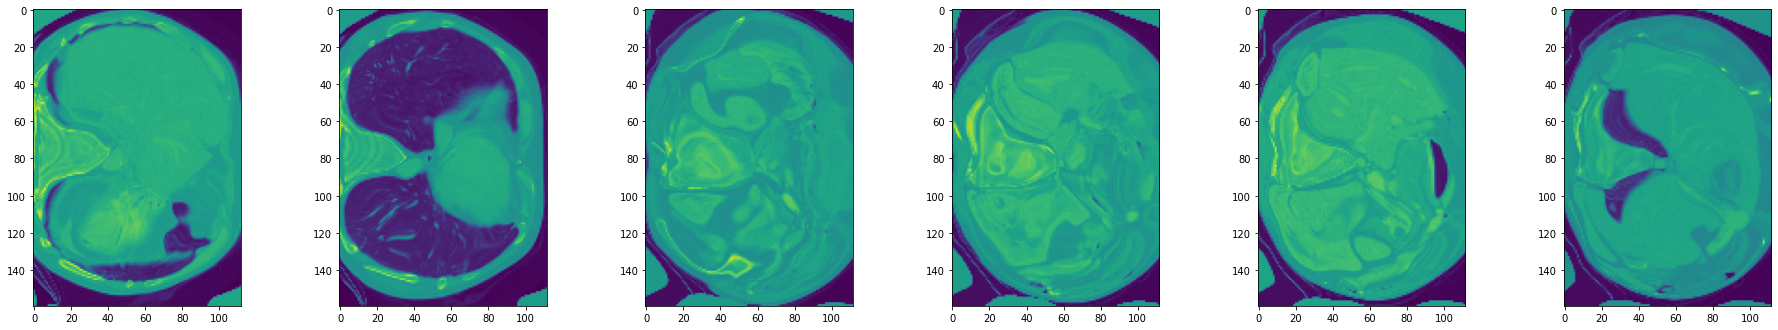

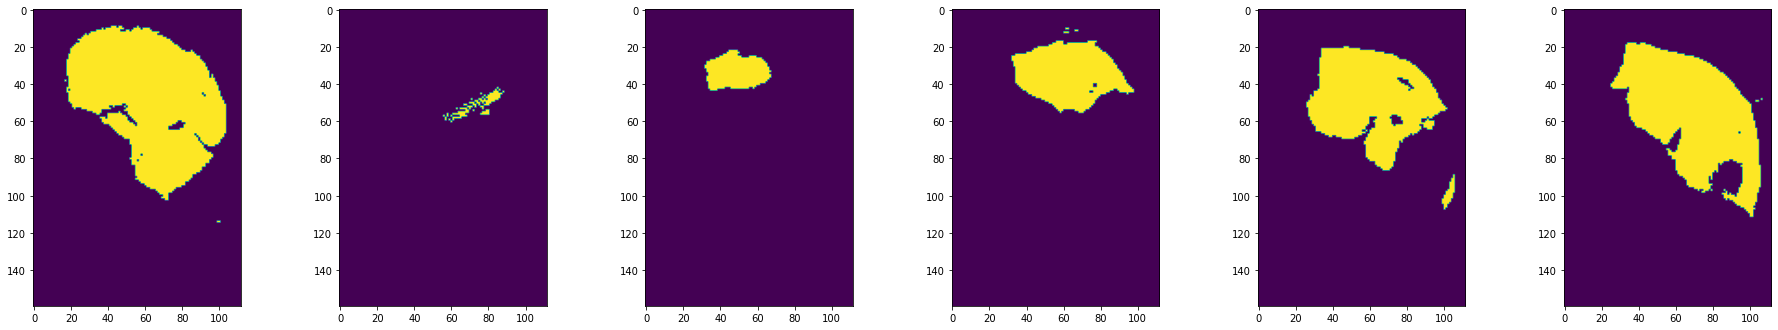

In [ ]:
x, y = (0.8, 0.1) # split with x = 80%, y = 10% and therefore z = 10%
lenx = int(len(raw_data)*x)
leny = int(len(raw_data)*(x+y))

xtrain, xvalidation, xtest = np.split(raw_data, [lenx, leny])
ytrain, yvalidation, ytest = np.split(labeled_data, [lenx, leny])

print("xtrain shape      : " + str(xtrain.shape))
print("ytrain shape      : " + str(ytrain.shape))
print("xvalidation shape : " + str(xvalidation.shape))
print("yvalidation shape : " + str(yvalidation.shape))
print("xtest shape       : " + str(xtest.shape))
print("ytest shape       : " + str(ytest.shape))


print_slices(xtest)
print_slices(ytest)

In [ ]:
# ---- entrainement ----

print("xtrain      : " + str(xtrain.shape))
print("ytrain      : " + str(ytrain.shape))
print("xvalidation : " + str(xvalidation.shape))
print("yvalidation : " + str(yvalidation.shape))

if DO_WE_LEARN:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 32,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model.save_weights(file_name)
else:
    model.load_weights(file_name)

xtrain      : (7173, 160, 112, 1)
ytrain      : (7173, 160, 112, 1)
xvalidation : (897, 160, 112, 1)
yvalidation : (897, 160, 112, 1)
Epoch 1/20
225/225 [==============================] - 70s 277ms/step - loss: 0.1783 - accuracy: 0.9229 - val_loss: 0.1474 - val_accuracy: 0.9529
Epoch 2/20
225/225 [==============================] - 59s 263ms/step - loss: 0.1185 - accuracy: 0.9643 - val_loss: 0.1383 - val_accuracy: 0.9503
Epoch 3/20
225/225 [==============================] - 59s 263ms/step - loss: 0.1068 - accuracy: 0.9715 - val_loss: 0.1235 - val_accuracy: 0.9685
Epoch 4/20
225/225 [==============================] - 58s 257ms/step - loss: 0.0997 - accuracy: 0.9759 - val_loss: 0.1201 - val_accuracy: 0.9729
Epoch 5/20
225/225 [==============================] - 60s 266ms/step - loss: 0.0949 - accuracy: 0.9786 - val_loss: 0.1161 - val_accuracy: 0.9745
Epoch 6/20
225/225 [==============================] - 60s 267ms/step - loss: 0.0906 - accuracy: 0.9810 - val_loss: 0.1144 - val_accuracy: 0.9

In [ ]:
prediction = model.predict(xtest)

29/29 [==============================] - 2s 74ms/step


(897, 160, 112, 1)
(897, 160, 112, 1)


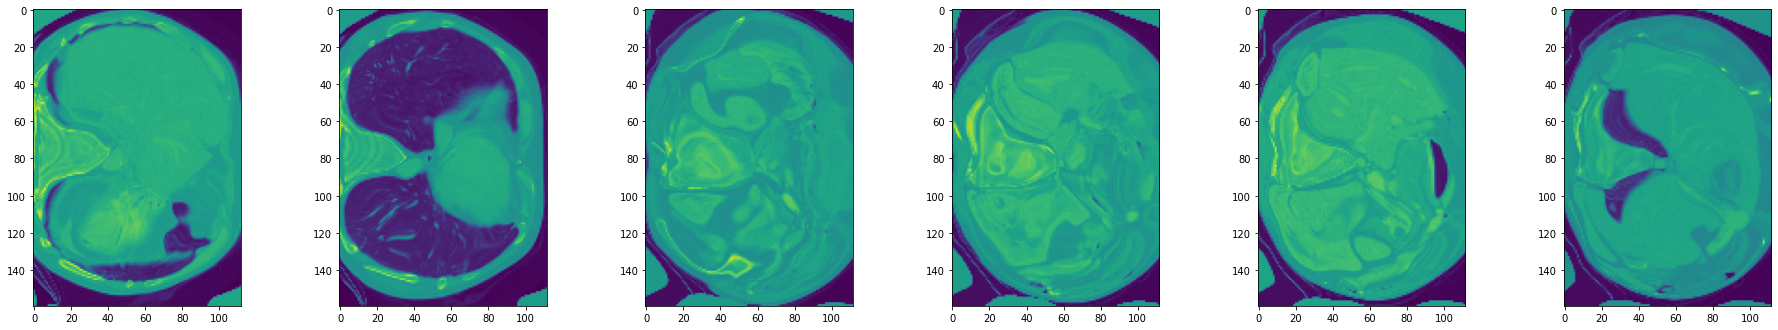

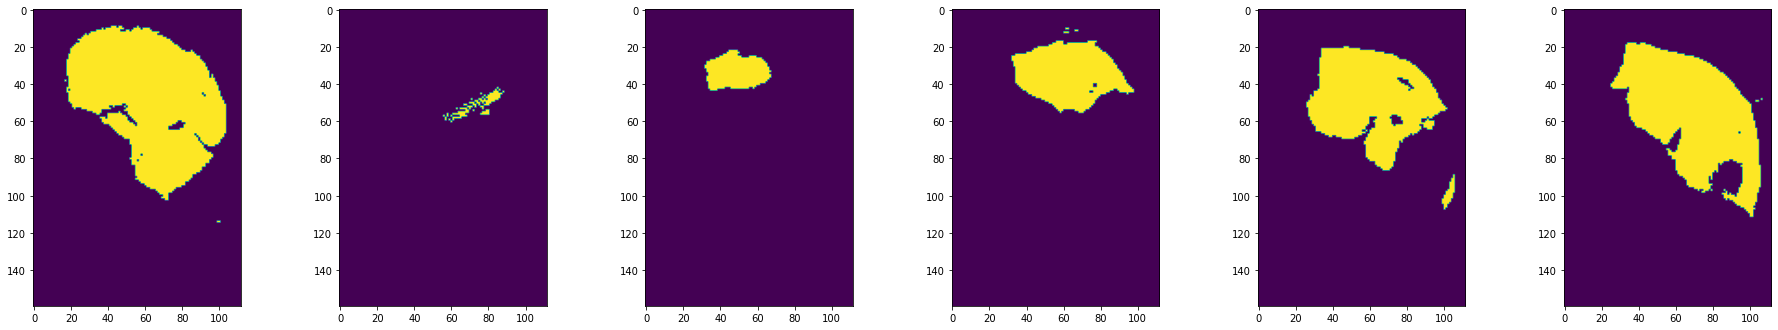

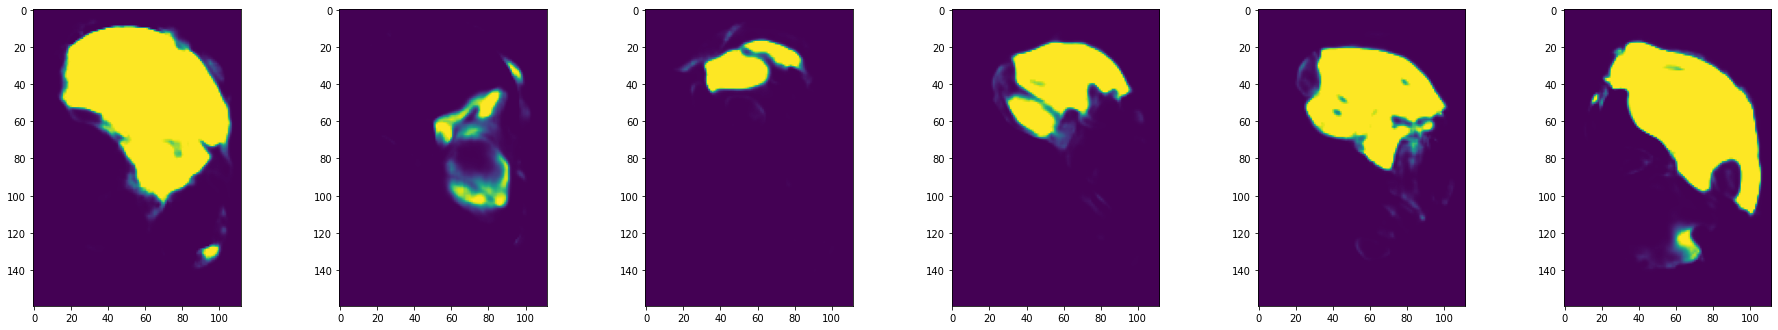

In [ ]:
print(xtest.shape)
print(ytest.shape)
print_slices(xtest)
print_slices(ytest)
print_slices(prediction)

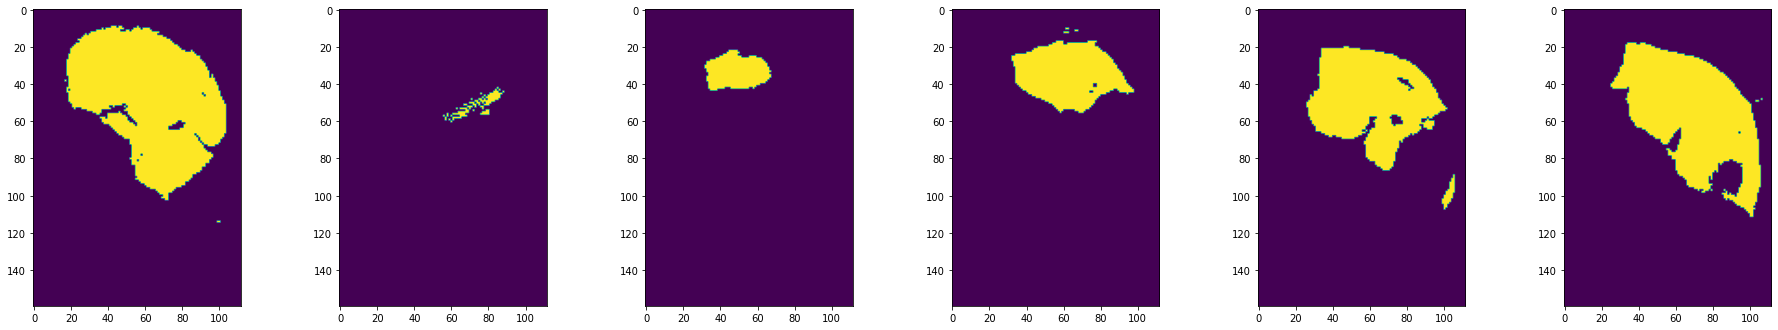

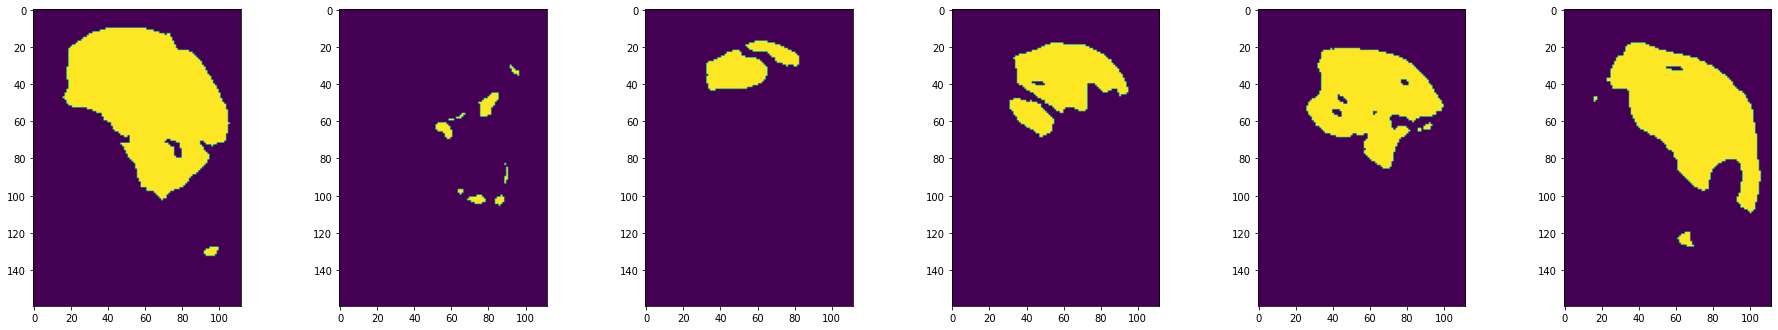

cardIntersec =  1106351
cardX =  1255647
cardY =  1338036
dice =  0.8531119647235225


In [ ]:
rounded_prediction = np.round(prediction)
print_slices(rounded_prediction)
dice = compute_dice(rounded_prediction, ytest)